In [1]:
import sys
sys.path.append('../..')
from TO.utils import check_package_status
check_package_status()

from experiments.utils import set_plt_template
set_plt_template()

<div class="alert alert-block alert-success" style="font-size: 14px; border-radius: 10px"><h4>[GO] TO @ 08acfa671be8254f9c3fbc72a5d02db6a97e98da
</h4><pre>  ✅ No changes found in the ./TO packge.</pre></div>

In [ ]:
from TO import Topology
from TO.parameterizations import Capsules
from TO.parameterizations.mmc import MMCCenterpointsConfig, MMCAngularConfig
from TO.problem import VolumeConstraint, DisconnectionConstraint, ProblemInstance

from TO.models import BinaryElasticMembraneModel
from TO.models.membrane import RigidEdge, Load
from TO.experiment import run_experiment

import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import box, Point, LineString


from tqdm import trange
from IPython.utils.io import capture_output

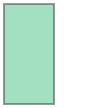

In [3]:
topology = Topology(
    continuous=True,
    # VERTICAL PROBLEM DOMAIN
    domain=box(0,0,50,100),
    density=1.
)
model = BinaryElasticMembraneModel(
    topology, 
    thickness=1, 
    E11=25, 
    E22=1, 
    G12=0.5, 
    nu12=0.25, 
    Emin=1e-9
)
# VERTICAL PROBLEM
model.bcs.add(RigidEdge(
    nodes=model.mesh.nodes[0, :], 
    state=model.state)
)
model.bcs.add(Load(
    nodes=[model.mesh.nodes[-1, model.mesh.nelx//2]],
    loads=[(-0.1, 0)],
))

topology.domain

In [4]:
parameterization_angular = Capsules(
    topology=topology,
    n_components_x=2,
    n_components_y=3,
    symmetry_x=True, # note we use symmtery x now, and the number of components are swapped
    symmetry_y=False,
    representation=MMCAngularConfig,
    n_samples=100
)

parameterization_centerpoints = Capsules(
    topology=topology,
    n_components_x=2,
    n_components_y=3,
    symmetry_x=True, # note we use symmtery x now, and the number of components are swapped
    symmetry_y=False,
    representation=MMCCenterpointsConfig,
    n_samples=100
)

In [5]:
topology_constraints = [
    VolumeConstraint(weight=1e9, max_relative_volume=0.5),
    DisconnectionConstraint(weight=1e3, boundaries=[
        # VERTICAL PROBLEM
        Point(topology.domain_size_x/2, 0),
        LineString([(0,topology.domain_size_y), (topology.domain_size_x, topology.domain_size_y)])
    ]),
]

In [6]:
n_runs = 30
budget = 500

for (exp, parameterization) in [
    ('angular-vertical', parameterization_angular),
    ('centerpoints-vertical', parameterization_centerpoints)
] :
    print(parameterization.representation)
    for seed in trange(n_runs):
        with capture_output():
            problem = ProblemInstance(topology, parameterization, model, topology_constraints, budget=500)
            run_experiment(problem, sigma0=0.25, seed=seed+1, name=exp)

<class 'TO.parameterizations.mmc.MMCAngularConfig'>


100%|██████████| 30/30 [27:20<00:00, 54.67s/it]


<class 'TO.parameterizations.mmc.MMCCenterpointsConfig'>


100%|██████████| 30/30 [25:52<00:00, 51.76s/it]


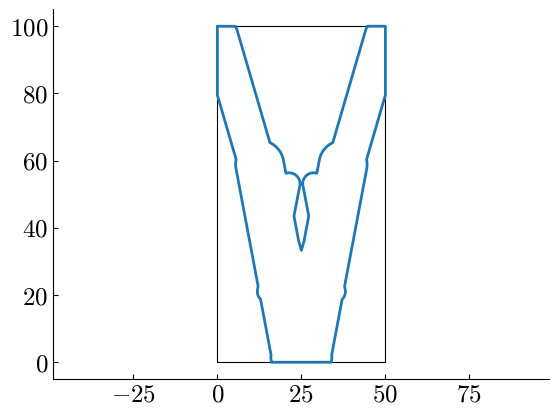

In [67]:
plt.plot(*topology.domain.exterior.xy, 'k', lw=.8)
plt.plot(*topology.geometry.geoms[0].exterior.xy, lw=2)
plt.axis('equal');

## Analysis

In [12]:
import matplotlib.pyplot as plt
import os
from typing import List

In [75]:
def read_evals(name: str, seed: int, run: int=None) -> List[str] :
    path = os.path.join(os.path.abspath(''), f'results/{name}/{seed}/evals.dat' if not(run) else f'results/{name}/{seed}-{run}/evals.dat')
    with open(path, 'r') as handle : return handle.readlines()

def get_fitness_values(name: str, seed: int, run: int=None) -> np.ndarray :
    lines = read_evals(name, seed, run)
    f = np.abs(np.array([float(line.split()[1]) for line in lines]))
    return f

def get_best_config(name:str, seed: int, run: int=None) -> np.ndarray : 
    lines = read_evals(name, seed, run)
    line_best = min(lines, key=lambda line : float(line.split()[1])) 
    return np.array([float(xi) for xi in line_best.split()[2:]])

In [50]:
import pickle
with open('../0401_mmc_representation/results.pkl', 'rb') as handle : experiments = pickle.load(handle)

In [51]:
experiments['angular-horizontal'] = experiments['angular']
experiments['centerpoints-horizontal'] = experiments['centerpoints']

angular-horizontal
angular-vertical
centerpoints-horizontal
centerpoints-vertical


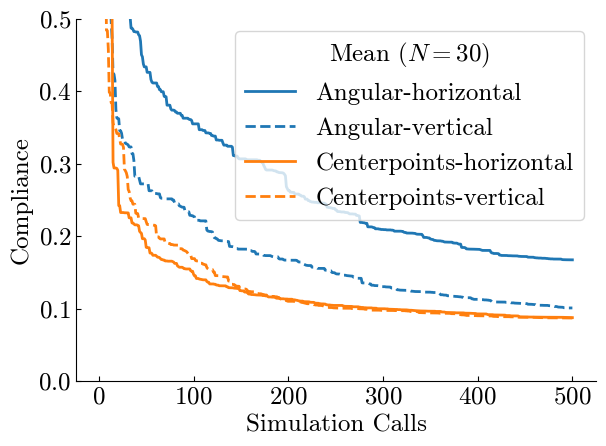

In [64]:
fig, ax = plt.subplots()

experiment_names = ('angular-horizontal', 'angular-vertical', 'centerpoints-horizontal', 'centerpoints-vertical')
color_idx = 0
for exp in experiment_names:
    print(exp)
    if exp not in experiments:
        X = np.empty((n_runs, budget))
        for i in range(n_runs) :
            try:
                x = get_fitness_values(exp, i+1)
                X[i,:x.size] = np.minimum.accumulate(x)
                if (x.size < budget) :
                    print(f'[{i+1:03d}/{n_runs:03d}] converged before exceeded budget @ {x.size} with fitness {x.min()}')
                    X[i,x.size:] = x.min()
            except FileNotFoundError:
                print(f'[{i+1:03d}/{n_runs:03d}] converged before calling the simulation')
                X[i, :] = np.nan 
        experiments[exp] = X.copy()
    else :
        X = experiments[exp].copy()
    X = X[~np.isnan(X).any(axis=1)]

    (Q2) = np.median(X, axis=0)
    (Q1, Q3) = np.percentile(X, [25, 75], axis=0)

    Q2 = np.mean(X, axis=0)

    ax.plot(np.arange(budget)+1, Q2, lw=2, label=exp.capitalize(), ls='--' if 'vertical' in exp else '-', c=f'C{color_idx}')
    # ax.fill_between(np.arange(budget)+1, Q1, Q3, alpha=.2)
    if 'vertical' in exp : color_idx += 1

ax.set_ylim(0, 0.5)

ax.legend(title=f'Mean ($N={n_runs}$)');ax.set_xlabel('Simulation Calls'); ax.set_ylabel('Compliance'); fig.tight_layout()

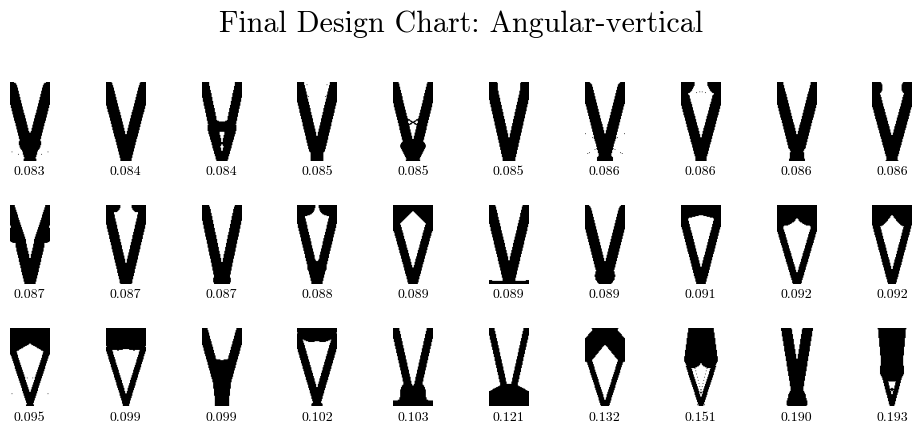

In [165]:
import json

f_best = np.zeros(n_runs)
x_best = np.zeros((n_runs, parameterization_angular.dimension))

for i in range(n_runs):
    with open(f'./results/angular-vertical/{i+1}/IOHprofiler_f0_TopologyOptimization.json') as handle : ioh_out = json.load(handle)
    best_run = ioh_out['scenarios'][0]['runs'][0]['best']
    (f_best[i], x_best[i]) = (best_run['y'], np.asarray(best_run['x']))
x_best_vertical = x_best.copy()

idx = np.argsort(f_best).reshape(-1,10)

fig, ax = plt.subplots(*idx.shape, figsize=(10,1.5*len(idx)))

for i in range(len(idx)):
    for j in range(len(idx[0])) :
        ax[i,j].set_xticks([])
        ax[i,j].set_yticks([])
        ax[i,j].spines[:].set_visible(False)
        parameterization.update_topology(topology, x_best[idx[i,j]])
        ax[i,j].imshow(topology.mask, cmap='binary')
        ax[i,j].set_xlabel(f'{f_best[idx[i,j]]:.3f}', fontsize=10)
fig.suptitle(f'Final Design Chart: {exp.capitalize()}')
fig.tight_layout()

In [138]:
topology_horizontal = Topology(
    continuous=True,
    domain=box(0,0,100,50),
    density=1.
)
parameterization_angular_horizontal = Capsules(
    topology_horizontal,
    n_components_x=3,
    n_components_y=2,
    symmetry_x=False,
    symmetry_y=True,
    representation=MMCAngularConfig,
    n_samples=100
)

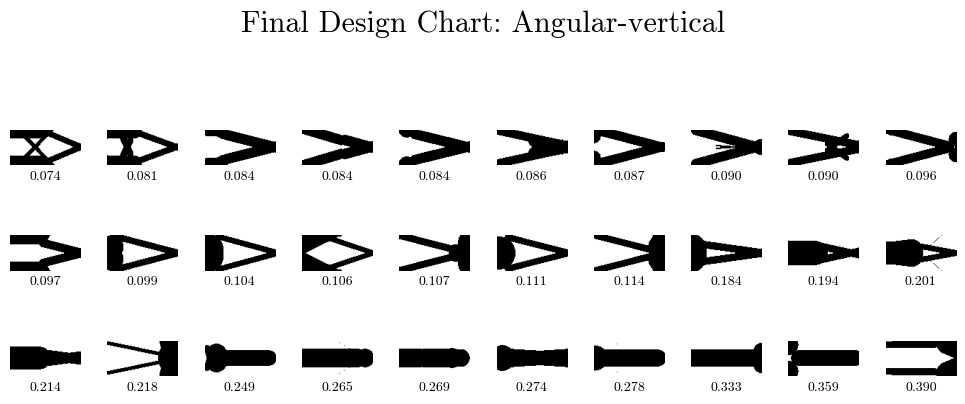

In [166]:
import json

f_best = np.zeros(n_runs)
x_best = np.zeros((n_runs, parameterization_angular_horizontal.dimension))

for i in range(n_runs):
    with open(f'../0401_mmc_representation/results/angular/{i+1}/IOHprofiler_f0_TopologyOptimization.json') as handle : ioh_out = json.load(handle)
    best_run = ioh_out['scenarios'][0]['runs'][0]['best']
    (f_best[i], x_best[i]) = (best_run['y'], np.asarray(best_run['x']))
x_best_horizontal = x_best.copy()

idx = np.argsort(f_best).reshape(-1,10)

fig, ax = plt.subplots(*idx.shape, figsize=(10,1.5*len(idx)))

for i in range(len(idx)):
    for j in range(len(idx[0])) :
        ax[i,j].set_xticks([])
        ax[i,j].set_yticks([])
        ax[i,j].spines[:].set_visible(False)
        parameterization_angular_horizontal.update_topology(topology_horizontal, x_best[idx[i,j]])
        ax[i,j].imshow(topology_horizontal.mask, cmap='binary')
        ax[i,j].set_xlabel(f'{f_best[idx[i,j]]:.3f}', fontsize=10)
fig.suptitle(f'Final Design Chart: {exp.capitalize()}')
fig.tight_layout()

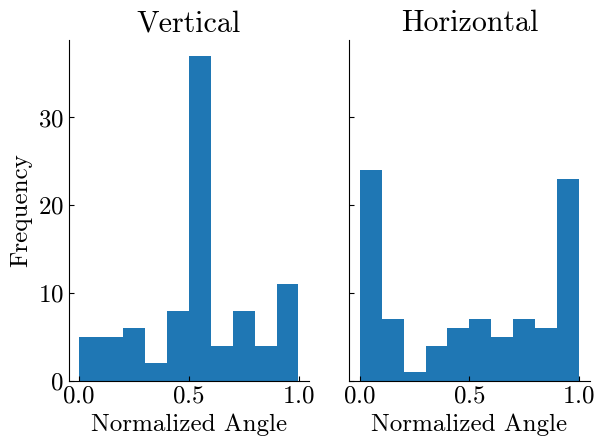

In [181]:
fig, ax = plt.subplots(1, 2, sharey=True)
ax[0].hist(x_best_vertical.reshape(-1, 3, 5)[:,:,-1].flatten()); ax[0].set_title('Vertical'); ax[0].set_xlabel('Normalized Angle'); ax[0].set_ylabel('Frequency')
ax[1].hist(x_best_horizontal.reshape(-1, 3, 5)[:,:,-1].flatten()); ax[1].set_title('Horizontal'); ax[1].set_xlabel('Normalized Angle')
fig.tight_layout()